# ML Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint, uniform, loguniform

In [2]:
# 1. 데이터 로드 및 전처리
df = pd.read_csv('AlNiFe_data2.csv')

# 예측용 그리드 데이터 (전체 영역 맵 생성용)
try:
    grid_df = pd.read_csv('Auxiliary_data2.csv')
    print(f"Grid Data Loaded: {grid_df.shape}")
except FileNotFoundError:
    grid_df = None
    print("Warning: 'Auxiliary_data2.csv' not found. Skipping full map prediction.")

# 독립 변수 및 종속 변수 설정
lon = np.array(df['X_utm'])
lat = np.array(df['Y_utm'])
al = np.array(df['AL'])
fe = np.array(df['FE'])
ni = np.array(df['NI'])

# 종속 변수인 AL, FE, NI와 ORIG_FID 제거
X = df.drop(['AL', 'FE', 'NI'], axis=1)

# 레이블 인코딩 (LITHOIDX)
# 학습 데이터와 그리드 데이터의 암상 코드를 통일하기 위해 함께 고려하거나, 학습 데이터 기준으로 처리
label_encoder = LabelEncoder()

if 'LITHOIDX' in df.columns:
    df['LITHOIDX_encoded'] = label_encoder.fit_transform(df['LITHOIDX'])
else:
    print("Warning: 'LITHOIDX' column not found in df. Skipping encoding.")

# Feature 선택 (X_label 생성)
# 타겟 변수 및 불필요한 컬럼 제거
targets = ['AL', 'FE', 'NI']
drop_cols = targets + ['ORIG_FID', 'LITHOIDX'] # LITHOIDX는 encoded 버전을 쓰므로 원본 제거
# 실제 데이터에 존재하는 컬럼만 drop
cols_to_drop = [c for c in drop_cols if c in df.columns]

X_label = df.drop(cols_to_drop, axis=1)
al = df['AL'] # 타겟 변수 (AL 기준)

print(f"Features: {X_label.columns.tolist()}")
print(f"Target: AL")

Grid Data Loaded: (164174, 11)
Features: ['X_utm', 'Y_utm', 'GRV_IDW', 'MAG_IDW', 'FaultDist', 'FaultDensity', 'DepositDist', 'LITHOIDX_encoded']
Target: AL


In [3]:
# 2. 데이터 분할 (7:2:1)
# 첫 번째 분할: Train (70%) + Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X_label, al, test_size=0.3, random_state=42)

# 두 번째 분할: Temp (30%) → Validation (20%) + Test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

print(f"Train Set: {X_train.shape[0]} samples (70%)")
print(f"Val Set:   {X_val.shape[0]} samples (20%)")
print(f"Test Set:  {X_test.shape[0]} samples (10%)")

Train Set: 190 samples (70%)
Val Set:   54 samples (20%)
Test Set:  28 samples (10%)


Train samples: 190
Test samples:  28

>>> Calculating Nearest Neighbor Distances...
----------------------------------------
Min Distance:    218.64 m
Mean Distance:   1019.71 m  <-- [Key Metric]
Median Distance: 843.83 m
Max Distance:    2798.76 m
----------------------------------------


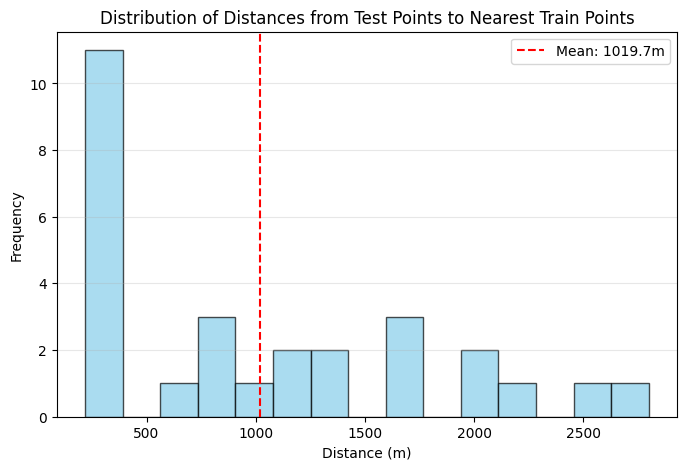

In [4]:
# Spatial Distance Analysis ===
from sklearn.neighbors import NearestNeighbors

coord_cols = ['X_utm', 'Y_utm']

train_coords = X_train[coord_cols].values
test_coords = X_test[coord_cols].values

print(f"Train samples: {len(train_coords)}")
print(f"Test samples:  {len(test_coords)}")

print("\n>>> Calculating Nearest Neighbor Distances...")

# 학습 데이터(Train)를 기준으로 공간 인덱싱 (Ball Tree 알고리즘 사용)
nn_model = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(train_coords)

# 테스트 데이터(Test)에서 가장 가까운 학습 데이터까지의 거리(distances)와 인덱스(indices) 계산
distances, indices = nn_model.kneighbors(test_coords)

#통계량 산출
min_dist = np.min(distances)
mean_dist = np.mean(distances)
median_dist = np.median(distances)
max_dist = np.max(distances)

print("-" * 40)
print(f"Min Distance:    {min_dist:.2f} m")
print(f"Mean Distance:   {mean_dist:.2f} m  <-- [Key Metric]")
print(f"Median Distance: {median_dist:.2f} m")
print(f"Max Distance:    {max_dist:.2f} m")
print("-" * 40)

plt.figure(figsize=(8, 5))
plt.hist(distances, bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(mean_dist, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_dist:.1f}m')
plt.title('Distribution of Distances from Test Points to Nearest Train Points')
plt.xlabel('Distance (m)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

In [5]:
# 3. Random Forest (RF) 분석
# 파라미터 그리드
rf_param_dist = {
    'n_estimators': randint(100, 1000),
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'bootstrap': [True, False]
}

rf_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=rf_param_dist,
    n_iter=100,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    error_score='raise'
)

rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
print(f"Best RF Params: {rf_search.best_params_}")

# 예측 및 평가
rf_pred_val = best_rf.predict(X_val)
rf_pred_test = best_rf.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred_test))
rf_r2 = r2_score(y_test, rf_pred_test)

print(f"[Result] RF Test RMSE: {rf_rmse:.4f}, R2: {rf_r2:.3f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best RF Params: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 732}
[Result] RF Test RMSE: 73.0591, R2: 0.634


In [6]:
# 4. XGBoost (XGB) 분석
# 파라미터 그리드
xgb_param_dist = {
    'n_estimators': randint(100, 1000),
    'learning_rate': loguniform(1e-3, 0.3),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 5),
    'reg_alpha': loguniform(1e-8, 10),
    'reg_lambda': loguniform(1e-8, 10)
}

xgb_search = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
    param_distributions=xgb_param_dist,
    n_iter=100,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    error_score='raise'
)

xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
print(f"Best XGB Params: {xgb_search.best_params_}")

# 예측 및 평가
xgb_pred_val = best_xgb.predict(X_val)
xgb_pred_test = best_xgb.predict(X_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred_test))
xgb_r2 = r2_score(y_test, xgb_pred_test)

print(f"[Result] XGB Test RMSE: {xgb_rmse:.4f}, R2: {xgb_r2:.3f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best XGB Params: {'colsample_bytree': np.float64(0.6467440873590191), 'gamma': np.float64(0.07039911357542228), 'learning_rate': np.float64(0.003108542042538474), 'max_depth': 5, 'n_estimators': 518, 'reg_alpha': np.float64(0.08738424135626986), 'reg_lambda': np.float64(4.638759594322625e-08), 'subsample': np.float64(0.6792328642721364)}
[Result] XGB Test RMSE: 79.1915, R2: 0.570


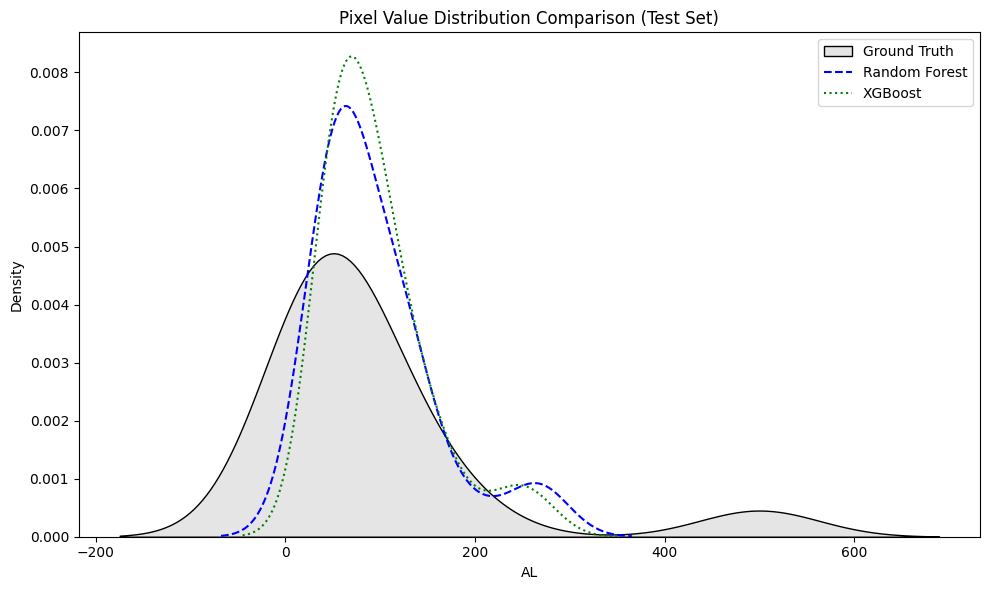

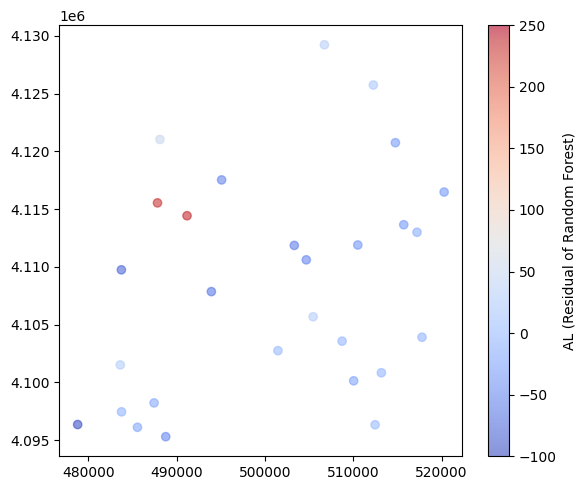

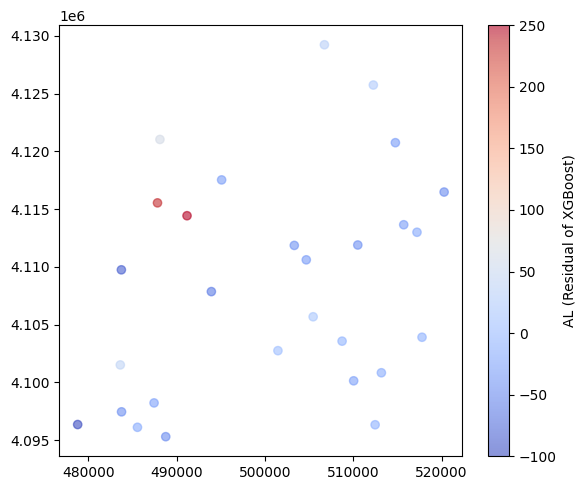

In [7]:
# 5. 결과 시각화 및 저장
# 5-1. 분포 비교 (Distribution Comparison)
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label='Ground Truth', color='black', fill=True, alpha=0.1)
sns.kdeplot(rf_pred_test, label='Random Forest', color='blue', linestyle='--')
sns.kdeplot(xgb_pred_test, label='XGBoost', color='green', linestyle=':')
plt.title('Pixel Value Distribution Comparison (Test Set)')
plt.legend()
plt.tight_layout()
# plt.savefig('Distribution_Comparison_ML.png')
plt.show()

# 5-2. 차분도 (Difference Maps) - Test Set에 대해
if 'X_utm' in X_test.columns and 'Y_utm' in X_test.columns:
    coords = X_test[['X_utm', 'Y_utm']].values
    
    # RF Residuals
    rf_resid = y_test - rf_pred_test
    # XGB Residuals
    xgb_resid = y_test - xgb_pred_test
    
    # RF Plot
    plt.figure(figsize=(6,5))
    sc1 = plt.scatter(coords[:, 0], coords[:, 1], c=rf_resid, cmap='coolwarm', alpha=0.6,vmin=-100, vmax=250)
#    plt.set_title(f'Random Forest Residuals (RMSE: {rf_rmse:.2f})')
    plt.colorbar(sc1, label='AL (Residual of Random Forest)')
    plt.tight_layout()
    plt.savefig('Difference_Map_RF.png', dpi=300)
    plt.show()
    
    # XGB Plot
    plt.figure(figsize=(6,5))
    sc2 = plt.scatter(coords[:, 0], coords[:, 1], c=xgb_resid, cmap='coolwarm', alpha=0.6,vmin=-100, vmax=250)
#    plt.set_title(f'XGBoost Residuals (RMSE: {xgb_rmse:.2f})')
    plt.colorbar(sc2, label='AL (Residual of XGBoost)')
    plt.savefig('Difference_Map_XGB.png', dpi=300)
    plt.tight_layout()
    plt.show()

# Aux

In [8]:
lon2 = grid_df['X_utm']
lat2 = grid_df['Y_utm']
Aux = grid_df.drop(['AL', 'FE', 'NI'], axis=1)

# 열 이름 변경
Aux = Aux.rename(columns={'LITHOIDX_M':'LITHOIDX'})

In [9]:
from scipy.interpolate import griddata

# 그리드 데이터 생성 (보간을 위해)
grid_lon, grid_lat = np.mgrid[min(lon2):max(lon2):1000j, min(lat2):max(lat2):1000j]

In [10]:
# 레이블 인코딩 적용
Aux_label_encoded = Aux.copy()
label_encoder = LabelEncoder()
Aux_label_encoded['LITHOIDX_encoded'] = label_encoder.fit_transform(Aux['LITHOIDX'])
X_label_aux = Aux_label_encoded.drop(['LITHOIDX'], axis=1)

In [11]:
X_label_aux

,X_utm,Y_utm,GRV_IDW,MAG_IDW,FaultDist,FaultDensity,DepositDist,LITHOIDX_encoded
0,477606.333048,4.107341e+06,-16.617006,-59.323414,6574.191895,0.000000,12096.69336,27
1,477706.329331,4.107341e+06,-16.561079,-60.337589,6484.597168,0.000000,12028.29980,27
2,477806.334487,4.107341e+06,-16.524437,-62.477898,6395.310547,0.000000,11960.35156,27
3,477906.330744,4.107341e+06,-16.502071,-64.143814,6306.346191,0.000000,11892.85547,27
4,478006.326992,4.107341e+06,-16.457165,-64.938103,6217.716797,0.000000,11825.81934,27
...,...,...,...,...,...,...,...,...
164169,521506.334443,4.131741e+06,19.439478,-4.717810,316.227753,149.466293,23015.21289,14
164170,521606.333046,4.131741e+06,19.482893,-4.466160,223.606796,149.466293,23067.07617,14
164171,521706.331659,4.131741e+06,19.520616,-3.724178,141.421356,149.466293,23119.25586,14
164172,521806.330284,4.131741e+06,19.579323,-3.728091,100.000000,149.466293,23171.75000,14


In [12]:
# Predict Aux data with a trained ML model (using Label Encoded data)
Aux_rf_pred = best_rf.predict(X_label_aux)
Aux_xgb_pred = best_xgb.predict(X_label_aux)

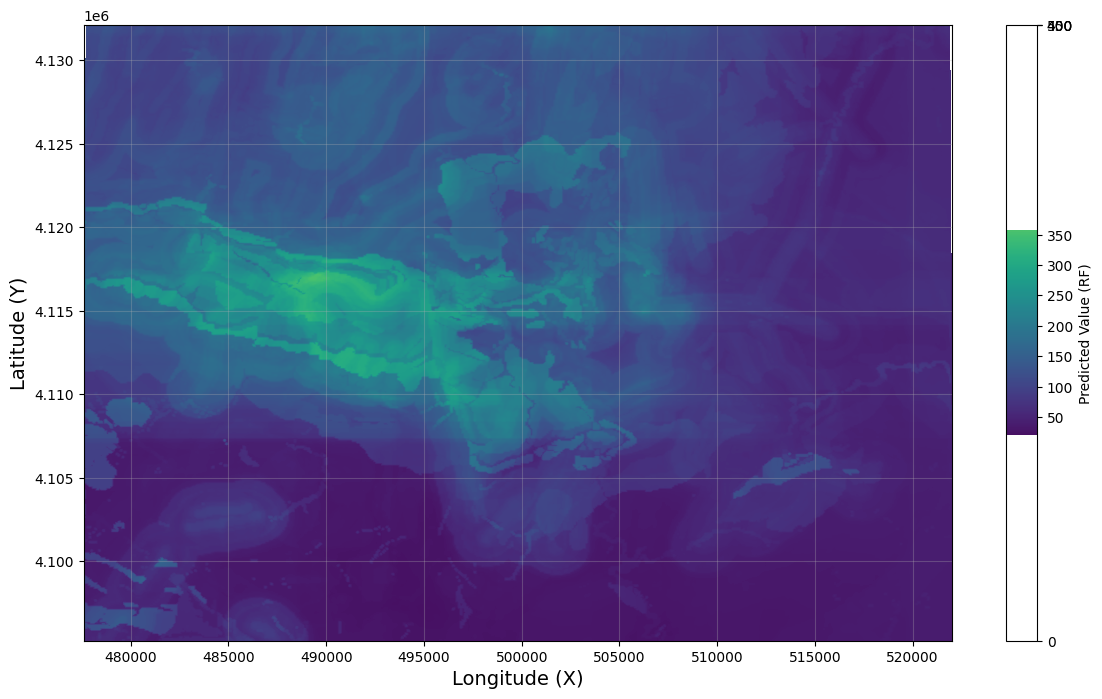

In [13]:
# 보간을 이용해 그리드 상의 z 값을 예측
grid_rf = griddata((lon2, lat2), Aux_rf_pred, (grid_lon, grid_lat), method='linear')

# 등고선 그래프 그리기
fig, ax = plt.subplots(figsize=(14, 8))
c = ax.contourf(grid_lon, grid_lat, grid_rf, levels=500, cmap='viridis', vmin=0, vmax=500)
cbar = fig.colorbar(c, label='Predicted Value (RF)')
cbar.set_ticks(np.linspace(0, 500, 11))
ax.set_xlabel('Longitude (X)', fontsize=14)
ax.set_ylabel('Latitude (Y)', fontsize=14)
#plt.title('Auxiliary Data Prediction using Random Forest')
plt.grid(True, alpha=0.3)
plt.show()

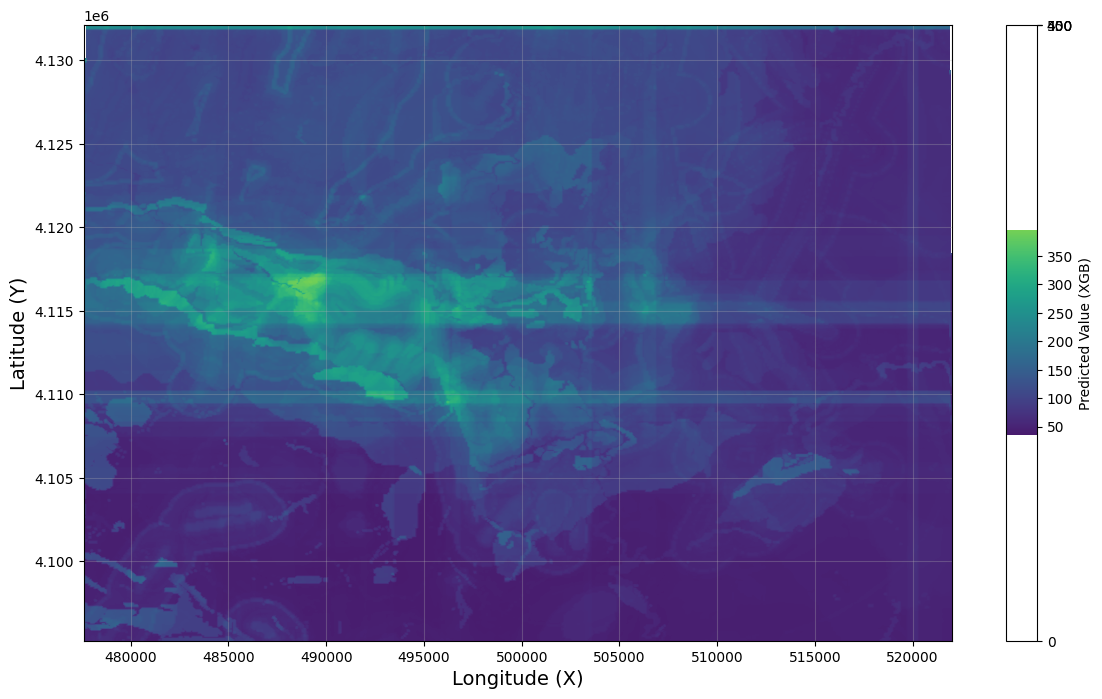

In [14]:
# 보간을 이용해 그리드 상의 z 값을 예측
grid_xgb = griddata((lon2, lat2), Aux_xgb_pred, (grid_lon, grid_lat), method='linear')

# 등고선 그래프 그리기
fig, ax = plt.subplots(figsize=(14, 8))
c = ax.contourf(grid_lon, grid_lat, grid_xgb, levels=500, cmap='viridis', vmin=0, vmax=500)
cbar = fig.colorbar(c, label='Predicted Value (XGB)')
cbar.set_ticks(np.linspace(0, 500, 11))
ax.set_xlabel('Longitude (X)', fontsize=14)
ax.set_ylabel('Latitude (Y)', fontsize=14)
#plt.title('Auxiliary Data Prediction (Contour plot) using XGBoost')
plt.grid(True, alpha=0.3)
plt.show()

# prediction extract

In [15]:
data = pd.read_csv('my_data.csv')

data['Random Forest'] = rf_pred_test
data['XGBoost'] = xgb_pred_test

data.to_csv('my_data.csv', index=False)